# The Battle of Neighborhood - Part2

### Introduction & Bussiness justification

#### Background

The City of New York, is the most populous city in the United States. It is the financial capital of USA. This also means that the market is highly competitive. It provides lot of business oppourtunities and business friendly environment. It has attracted many different players into the market. It is a global hub of business and commerce. There are more than 2 million small businesses in New York state, which employ 4 million people. These small businesses make up 99.8% of all businesses within the state and employ more than half the state's workforce.

Toronto is also a very popular city of US. It is highly developed due to many IT industries nearby. Immigrants also find Toronto highly stable for living. Markets around Toronto are also very rich.There are around 1 million small business around Toronto, which employ 2 million people. 

 People from diverse area lives here. As it is highly developed city so cost of doing business is also one of the highest. With it’s diverse culture , comes diverse food items. There are many restaurants in New York City, each belonging to different categories like Chinese , Indian , French etc. We need to analyze which immigrants are more, so that we can get an idea about the resturant style.

#### Things to keep in mind: 

A restaurant is such a business where the business personel has to keep in mind customer demand based on the population type nearby. The popular cuisine nearby. The City of New York & Toronto is famous for its excelllent cuisine. It's food culture includes an array of international cuisines influenced by the city's immigrant history.

Central and Eastern European immigrants, especially Jewish immigrants - bagels, cheesecake, hot dogs etc
Italian immigrants -  pizza and Italian cuisine
Chinese , Asian and Middle Eastern restaurants- sandwich joints, lebanese, kababs and many more
mobile food vendors - Some 4,000 licensed by the city.

So it is evident that to survive in such competitive market it is very important to startegically plan. Various factors need to be studied inorder to decide on the Location such as :

New York Population including immigrants & natives.
Markets, Wholesale markets etc nearby so that the ingredients can be purchased fresh to maintain quality and cost.
venues like Gyms, Entertainmnet zones, Parks etc nearby where floating population is high etc
already established branded open resturants & food joints.
Varieties available there.
Segmentation of the Borough
Saturated markets etc
The list can go on...
Eventhough well funded,The Company need to choose the correct location to start its first venture.If this is successful they can plan about expantion, but the first foot step is needs to be very calculative.

#### Target Audience:

To recommend the correct location,Company has appointed the Data Science team. The objective is to locate and recommend to the management which neighborhood of Newyork city will be best choice to start a restaurant. The Management also expects the team to keep their demands in mind.
This would be a challenging job now to hit the correct audience.

#### Challenges to face:

We need to compare two cities with their geographical boundaries. We need to compare different data sets. We need to provide detailed analysis on different datasets.

### Prerequisites 

#### Data

1. NewYork DataSet :  https://geo.nyu.edu/catalog/nyu_2451_34572
2. Toronto DataSet : https://www.toronto.ca/city-government/data-research-maps/open-data/open-data-catalogue/#8c732154-5012-9afe-d0cd-ba3ffc813d5a
3. NewYork cuisine : https://en.wikipedia.org/wiki/Cuisine_of_New_York_City
4. Toronto cuisine : https://en.wikipedia.org/wiki/Cuisine_in_Toronto


In [1]:

import numpy as np
import pandas as pd
import datetime as dt # Datetime
import json # library to handle JSON files

!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim

!conda install -c conda-forge folium=0.5.0 --yes
import folium #import folium # map rendering library

print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    certifi-2019.11.28         |           py36_0         149 KB  conda-forge
    geopy-1.20.0               |             py_0          57 KB  conda-forge
    openssl-1.1.1d             |       h516909a_0         2.1 MB  conda-forge
    ca-certificates-2019.11.28 |       hecc5488_0         145 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.5 MB

The following NEW packages will be INSTALLED:

    geographiclib:   1.50-py_0         conda-forge
    geopy:           1.20.0-py_0       conda-forge

The following packages will be UPDATED:

    ca-

In [2]:
# import package and its set of stopwords
!conda  install -c geopandas
!conda install -c conda-forge wordcloud==1.4.1 --yes
from PIL import Image
from wordcloud import WordCloud, STOPWORDS
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt
import csv
mpl.style.use('ggplot') # optional: for ggplot-like style

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import matplotlib.ticker as ticker

# notice: installing seaborn might takes a few minutes
!conda install -c anaconda seaborn -y
import seaborn as sns

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

# check for latest version of Matplotlib
print ('Matplotlib version: ', mpl.__version__) # >= 2.0.0


print ('Wordcloud is installed and imported!')


CondaValueError: too few arguments, must supply command line package specs or --file

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - wordcloud==1.4.1


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    wordcloud-1.4.1            |           py36_0         324 KB  conda-forge

The following NEW packages will be INSTALLED:

    wordcloud: 1.4.1-py36_0 conda-forge


wordcloud-1.4.1      | 324 KB    | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: done
Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - seaborn


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    c

In [3]:

!conda install -c conda-forge adal --yes
import getopt
import sys
import json
import re
from adal import AuthenticationContext
from project_lib import project

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - adal


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    pyjwt-1.7.1                |             py_0          17 KB  conda-forge
    adal-1.2.2                 |             py_0          32 KB  conda-forge
    ------------------------------------------------------------
                                           Total:          50 KB

The following NEW packages will be INSTALLED:

    adal:  1.2.2-py_0 conda-forge
    pyjwt: 1.7.1-py_0 conda-forge


pyjwt-1.7.1          | 17 KB     | ##################################### | 100% 
adal-1.2.2           | 32 KB     | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: done


In [10]:
import matplotlib.cm as cm
import matplotlib.colors as colors

#### Importing Toronto data

In [11]:
from bs4 import BeautifulSoup
import lxml
import requests
toronto_url = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M')
print('Toronto data taken into account')


Toronto data taken into account


In [12]:
soup = BeautifulSoup(toronto_url.text, 'html.parser')
table=soup.find('table', attrs={'class':'wikitable sortable'})

#get headers:
headers=table.findAll('th')
for i, head in enumerate(headers): headers[i]=str(headers[i]).replace("<th>","").replace("</th>","").replace("\n","")

#Find all items and skip first one:
rows=table.findAll('tr')
rows=rows[1:len(rows)]

# skip all meta symbols and line feeds between rows:
for i, row in enumerate(rows): rows[i] = str(rows[i]).replace("\n</td></tr>","").replace("<tr>\n<td>","")

# make dataframe, expand rows and drop the old one:
toronto_df=pd.DataFrame(rows)
toronto_df[headers] = toronto_df[0].str.split("</td>\n<td>", n = 2, expand = True) 
toronto_df.drop(columns=[0],inplace=True)

In [15]:
# skip not assigned boroughs:
toronto_df = toronto_df.drop(toronto_df[(toronto_df.Borough == "Not assigned")].index)
# give "Not assigned" Neighborhoods same name as Borough:
toronto_df.Neighborhood.replace("Not assigned", toronto_df.Borough, inplace=True)

# copy Borough value to Neighborhood if NaN:
toronto_df.Neighborhood.fillna(toronto_df.Borough, inplace=True)
# drop duplicate rows:
toronto_df=toronto_df.drop_duplicates()

# extract titles from columns
toronto_df.update(
    toronto_df.Neighborhood.loc[
        lambda x: x.str.contains('title')
    ].str.extract('title=\"([^\"]*)',expand=False))

toronto_df.update(
    toronto_df.Borough.loc[
        lambda x: x.str.contains('title')
    ].str.extract('title=\"([^\"]*)',expand=False))

# delete Toronto annotation from Neighbourhood:
toronto_df.update(
    toronto_df.Neighborhood.loc[
        lambda x: x.str.contains('Toronto')
    ].str.replace(", Toronto",""))
toronto_df.update(
    toronto_df.Neighborhood.loc[
        lambda x: x.str.contains('Toronto')
    ].str.replace("\(Toronto\)",""))

# combine multiple neighborhoods with the same post code
df2 = pd.DataFrame({'Postcode':toronto_df.Postcode.unique()})
df2['Borough']=pd.DataFrame(list(set(toronto_df['Borough'].loc[toronto_df['Postcode'] == x['Postcode']])) for i, x in df2.iterrows())
df2['Neighborhood']=pd.Series(list(set(toronto_df['Neighborhood'].loc[toronto_df['Postcode'] == x['Postcode']])) for i, x in df2.iterrows())
df2['Neighborhood']=df2['Neighborhood'].apply(lambda x: ', '.join(x))
df2.dtypes

df2.head()

,Postcode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,Regent Park
3,M6A,North York,"Lawrence Heights, Lawrence Manor"
4,M7A,Queen's Park (Toronto),Queen's Park


In [16]:
dfll= pd.read_csv("http://cocl.us/Geospatial_data")
dfll.rename(columns={'Postal Code':'Postcode'}, inplace=True)
dfll.set_index("Postcode")
df2.set_index("Postcode")
toronto_data=pd.merge(df2, dfll)
toronto_data.head()

,Postcode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,Regent Park,43.654260,-79.360636
3,M6A,North York,"Lawrence Heights, Lawrence Manor",43.718518,-79.464763
4,M7A,Queen's Park (Toronto),Queen's Park,43.662301,-79.389494


#### map of Toronto with neighborhoods superimposed on top

In [17]:
address = 'Toronto, ON, Canada'

geolocator = Nominatim(user_agent="to_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto, ON, Canada are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto, ON, Canada are 43.653963, -79.387207.


In [18]:
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(toronto_data['Latitude'], toronto_data['Longitude'], toronto_data['Borough'], toronto_data['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='green',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto


Display the number of Boroughs and Neighborhoods

In [19]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(toronto_data['Borough'].unique()),
        toronto_data.shape[0]
    )
)

The dataframe has 12 boroughs and 103 neighborhoods.


In [20]:
toronto_df = toronto_data[toronto_data['Borough'].str.contains('Toronto')].reset_index(drop=True)
toronto_df.head()

,Postcode,Borough,Neighborhood,Latitude,Longitude
0,M5A,Downtown Toronto,Regent Park,43.654260,-79.360636
1,M7A,Queen's Park (Toronto),Queen's Park,43.662301,-79.389494
2,M9A,Downtown Toronto,Queen's Park,43.667856,-79.532242
3,M1B,"Scarborough, Toronto","Rouge, Malvern",43.806686,-79.194353
4,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937


In [21]:
toronto_df['Borough'].unique()

array(['Downtown Toronto', "Queen's Park (Toronto)",
       'Scarborough, Toronto', 'East Toronto', 'West Toronto',
       'York, Toronto', 'Central Toronto'], dtype=object)

In [22]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(toronto_df['Borough'].unique()),
        toronto_df.shape[0]
    )
)

The dataframe has 7 boroughs and 60 neighborhoods.


#### Toronto cuisine

In [23]:
latitude = 43.6532
longitude = 79.3832

print('The geograpical coordinate of Manhattan are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Manhattan are 43.6532, 79.3832.


In [24]:
# The code was removed by Watson Studio for sharing.

In [25]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [26]:
LIMIT = 100
toronto_venues = getNearbyVenues(names=toronto_data['Neighborhood'],
                                   latitudes=toronto_data['Latitude'],
                                   longitudes=toronto_data['Longitude']
                                  )

Parkwoods
Victoria Village
Regent Park
Lawrence Heights, Lawrence Manor
Queen's Park 
Queen's Park 
Rouge, Malvern
Don Mills North
Woodbine Gardens, Parkview Hill
Garden District, Ryerson
Glencairn
Martin Grove, Cloverdale, West Deane Park, Islington, Princess Gardens
Rouge Hill, Highland Creek , Port Union
Don Mills South, Flemingdon Park
Woodbine Heights
St. James Town
Humewood-Cedarvale
Bloordale Gardens, Eringate, Markland Wood, Old Burnhamthorpe
Morningside, Guildwood, West Hill
The Beaches
Berczy Park
Caledonia-Fairbanks
Woburn
Leaside
Central Bay Street
Christie
Cedarbrae
Hillcrest Village
Bathurst Manor, Downsview North, Wilson Heights
Thorncliffe Park
King, Adelaide, Richmond
Dovercourt Village, Dufferin
Scarborough Village
Fairview, Oriole, Henry Farm
York University, Northwood Park
East Toronto
Toronto Islands, Union Station , Harbourfront East
Trinity–Bellwoods, Little Portugal
East Birchmount Park, Ionview, Kennedy Park
Bayview Village
CFB Toronto, Downsview East
The Danfo

In [27]:
print(toronto_venues.shape)
toronto_venues.head()

(2223, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park
1,Parkwoods,43.753259,-79.329656,Variety Store,43.751974,-79.333114,Food & Drink Shop
2,Victoria Village,43.725882,-79.315572,Victoria Village Arena,43.723481,-79.315635,Hockey Arena
3,Victoria Village,43.725882,-79.315572,Tim Hortons,43.725517,-79.313103,Coffee Shop
4,Victoria Village,43.725882,-79.315572,Portugril,43.725819,-79.312785,Portuguese Restaurant


Venues in each neighborhood

In [28]:
toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Agincourt,5,5,5,5,5,5
"Bathurst Manor, Downsview North, Wilson Heights",20,20,20,20,20,20
"Bathurst Quay, Harbourfront West, King and Spadina, CN Tower, South Niagara, Island airport, Railway Lands",16,16,16,16,16,16
Bayview Village,4,4,4,4,4,4
Berczy Park,57,57,57,57,57,57
"Bloordale Gardens, Eringate, Markland Wood, Old Burnhamthorpe",9,9,9,9,9,9
Business Reply Mail Processing Centre 969 Eastern,19,19,19,19,19,19
"CFB Toronto, Downsview East",3,3,3,3,3,3
"Cabbagetown, St. James Town",46,46,46,46,46,46


In [29]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 270 uniques categories.


### Analyzing neighborhoods

In [30]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Yoga Studio,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [31]:
venue_counts_toronto = toronto_onehot.groupby('Neighborhood').sum()
venue_counts_toronto.head(5)

,Yoga Studio,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store
Neighborhood,,,,,,,,,,,,,,,,,,,,,
Agincourt,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"Bathurst Manor, Downsview North, Wilson Heights",0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
"Bathurst Quay, Harbourfront West, King and Spadina, CN Tower, South Niagara, Island airport, Railway Lands",0,0,0,1,1,1,2,2,2,0,...,0,0,0,0,0,0,0,0,0,0
Bayview Village,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Berczy Park,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


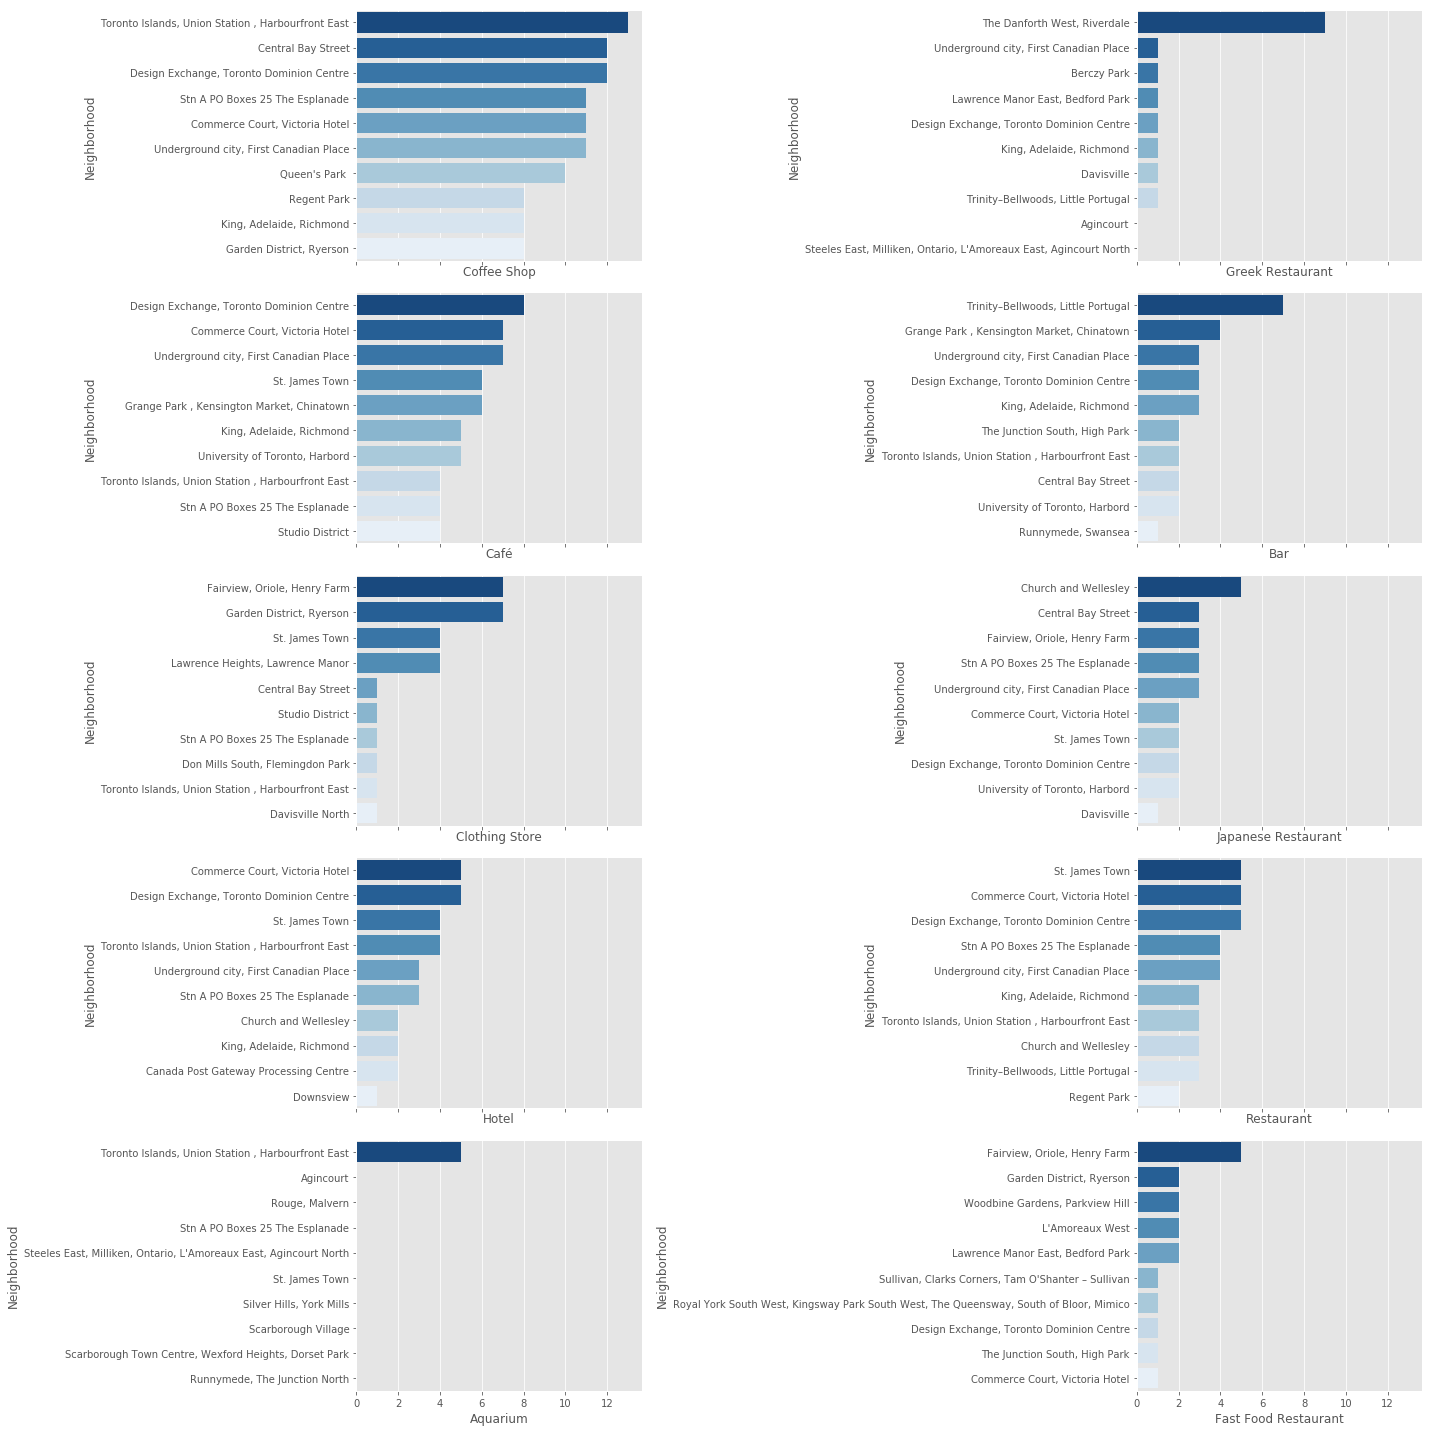

In [32]:
venue_counts_described_toronto = venue_counts_toronto.describe().transpose()
toronto_venue_top10 = venue_counts_described_toronto.sort_values('max', ascending=False)[0:10]
toronto_venue_top10
toronto_venue_top10_list = toronto_venue_top10.index.values.tolist()

import seaborn as sns
import matplotlib.pyplot as plt

fig, axes =plt.subplots(5, 2, figsize=(20,20), sharex=True)
axes = axes.flatten()

for ax, category in zip(axes, toronto_venue_top10_list):
    data = venue_counts_toronto[[category]].sort_values([category], ascending=False)[0:10]
    pal = sns.color_palette("Blues", len(data))
    sns.barplot(x=category, y=data.index, data=data, ax=ax, palette=np.array(pal[::-1]))

plt.tight_layout()
plt.show();


In [33]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped.head()

,Neighborhood,Yoga Studio,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,...,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,Agincourt,0.0,0.0,0.0,0.0000,0.0000,0.0000,0.000,0.000,0.000,...,0.0,0.000000,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0
1,"Bathurst Manor, Downsview North, Wilson Heights",0.0,0.0,0.0,0.0000,0.0000,0.0000,0.000,0.000,0.000,...,0.0,0.000000,0.0,0.05,0.0,0.0,0.0,0.0,0.0,0.0
2,"Bathurst Quay, Harbourfront West, King and Spa...",0.0,0.0,0.0,0.0625,0.0625,0.0625,0.125,0.125,0.125,...,0.0,0.000000,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0
3,Bayview Village,0.0,0.0,0.0,0.0000,0.0000,0.0000,0.000,0.000,0.000,...,0.0,0.000000,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0
4,Berczy Park,0.0,0.0,0.0,0.0000,0.0000,0.0000,0.000,0.000,0.000,...,0.0,0.017544,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0


The Elbow Method

In [34]:
from sklearn.cluster import KMeans
toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)
sum_of_squared_distances = []
K = range(1,50)
for k in K:
    print(k, end=' ')
    kmeans = KMeans(n_clusters=k).fit(toronto_grouped_clustering)
    sum_of_squared_distances.append(kmeans.inertia_)

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 

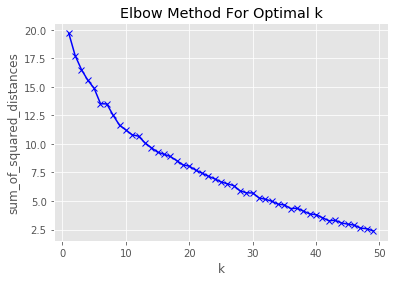

In [35]:
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('sum_of_squared_distances')
plt.title('Elbow Method For Optimal k');

In [36]:
num_top_venues = 10

for hood in toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Agincourt----
                       venue  freq
0  Latin American Restaurant   0.2
1                     Lounge   0.2
2             Breakfast Spot   0.2
3             Clothing Store   0.2
4               Skating Rink   0.2
5                Yoga Studio   0.0
6   Mediterranean Restaurant   0.0
7         Miscellaneous Shop   0.0
8  Middle Eastern Restaurant   0.0
9         Mexican Restaurant   0.0


----Bathurst Manor, Downsview North, Wilson Heights----
                       venue  freq
0                Coffee Shop  0.10
1                   Pharmacy  0.05
2                Gas Station  0.05
3              Shopping Mall  0.05
4             Sandwich Place  0.05
5  Middle Eastern Restaurant  0.05
6                Supermarket  0.05
7        Fried Chicken Joint  0.05
8           Sushi Restaurant  0.05
9         Frozen Yogurt Shop  0.05


----Bathurst Quay, Harbourfront West, King and Spadina, CN Tower, South Niagara, Island airport, Railway Lands----
                 venue  freq
0     Ai

In [37]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [38]:
import numpy as np
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Latin American Restaurant,Skating Rink,Clothing Store,Breakfast Spot,Lounge,Women's Store,Doner Restaurant,Dim Sum Restaurant,Diner,Discount Store
1,"Bathurst Manor, Downsview North, Wilson Heights",Coffee Shop,Shopping Mall,Pharmacy,Supermarket,Sushi Restaurant,Deli / Bodega,Restaurant,Fast Food Restaurant,Middle Eastern Restaurant,Pizza Place
2,"Bathurst Quay, Harbourfront West, King and Spa...",Airport Service,Airport Terminal,Airport Lounge,Harbor / Marina,Rental Car Location,Coffee Shop,Boat or Ferry,Boutique,Bar,Airport Gate
3,Bayview Village,Café,Chinese Restaurant,Japanese Restaurant,Bank,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant
4,Berczy Park,Coffee Shop,Cocktail Bar,Seafood Restaurant,Farmers Market,Beer Bar,Steakhouse,Bakery,Café,Cheese Shop,Concert Hall


### Cluster Neighborhoods

In [39]:
from sklearn.cluster import KMeans
# set number of clusters
kclusters = 7

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 0, 0, 0, 0, 0, 0, 1, 0, 1], dtype=int32)

In [40]:
neighborhoods_venues_sorted.insert(0, 'Cluster_Labels', kmeans.labels_)

toronto_merged = toronto_data

toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
toronto_merged.drop([16], inplace=True)
toronto_merged.reset_index()

toronto_merged

,Postcode,Borough,Neighborhood,Latitude,Longitude,Cluster_Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M3A,North York,Parkwoods,43.753259,-79.329656,1.0,Park,Food & Drink Shop,Dog Run,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Doner Restaurant,Ethiopian Restaurant
1,M4A,North York,Victoria Village,43.725882,-79.315572,0.0,Intersection,Coffee Shop,Pizza Place,Hockey Arena,Portuguese Restaurant,Dog Run,Department Store,Dessert Shop,Dim Sum Restaurant,Diner
2,M5A,Downtown Toronto,Regent Park,43.654260,-79.360636,0.0,Coffee Shop,Park,Pub,Bakery,Breakfast Spot,Restaurant,Café,Mexican Restaurant,Shoe Store,Chocolate Shop
3,M6A,North York,"Lawrence Heights, Lawrence Manor",43.718518,-79.464763,0.0,Clothing Store,Furniture / Home Store,Women's Store,Coffee Shop,Shoe Store,Miscellaneous Shop,Boutique,Vietnamese Restaurant,Accessories Store,Gift Shop
4,M7A,Queen's Park (Toronto),Queen's Park,43.662301,-79.389494,0.0,Coffee Shop,Diner,Park,Gym,Sandwich Place,Sushi Restaurant,Bar,Portuguese Restaurant,Café,Yoga Studio
5,M9A,Downtown Toronto,Queen's Park,43.667856,-79.532242,0.0,Coffee Shop,Diner,Park,Gym,Sandwich Place,Sushi Restaurant,Bar,Portuguese Restaurant,Café,Yoga Studio
6,M1B,"Scarborough, Toronto","Rouge, Malvern",43.806686,-79.194353,0.0,Fast Food Restaurant,Women's Store,Doner Restaurant,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Donut Shop
7,M3B,North York,Don Mills North,43.745906,-79.352188,0.0,Café,Gym / Fitness Center,Japanese Restaurant,Caribbean Restaurant,Doner Restaurant,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run
8,M4B,East York,"Woodbine Gardens, Parkview Hill",43.706397,-79.309937,0.0,Pizza Place,Fast Food Restaurant,Bank,Gym / Fitness Center,Pharmacy,Gastropub,Athletics & Sports,Intersection,Discount Store,Department Store
9,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,0.0,Coffee Shop,Clothing Store,Cosmetics Shop,Café,Middle Eastern Restaurant,Tea Room,Diner,Ramen Restaurant,Bookstore,Plaza


In [41]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster_Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        #color=rainbow[int(cluster)-1],
        fill=True,
        #fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Examine Clusters

Now, examine each cluster and determine the discriminating venue categories that distinguish each cluster. Based on the defining categories, assign a name to each cluster.



In [42]:

required_column_indices = [1,6,7]
required_column = [list(toronto_merged.columns.values)[i] for i in required_column_indices]
required_column_indices = [1,6,7]

Cluster 0

In [43]:
cluster0 = toronto_merged.loc[toronto_merged['Cluster_Labels'] == 0, toronto_merged.columns[1:12]]
cluster0.head(5)

,Borough,Neighborhood,Latitude,Longitude,Cluster_Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue
1,North York,Victoria Village,43.725882,-79.315572,0.0,Intersection,Coffee Shop,Pizza Place,Hockey Arena,Portuguese Restaurant,Dog Run
2,Downtown Toronto,Regent Park,43.654260,-79.360636,0.0,Coffee Shop,Park,Pub,Bakery,Breakfast Spot,Restaurant
3,North York,"Lawrence Heights, Lawrence Manor",43.718518,-79.464763,0.0,Clothing Store,Furniture / Home Store,Women's Store,Coffee Shop,Shoe Store,Miscellaneous Shop
4,Queen's Park (Toronto),Queen's Park,43.662301,-79.389494,0.0,Coffee Shop,Diner,Park,Gym,Sandwich Place,Sushi Restaurant
5,Downtown Toronto,Queen's Park,43.667856,-79.532242,0.0,Coffee Shop,Diner,Park,Gym,Sandwich Place,Sushi Restaurant


In [44]:
for col in required_column:
    print(cluster0[col].value_counts(ascending = False))
    print("---------------------------------------------")

North York                18
Downtown Toronto          18
Scarborough, Toronto      13
Etobicoke                  9
Central Toronto            8
West Toronto               6
East Toronto               5
East York                  4
York, Toronto              2
Mississauga                1
Queen's Park (Toronto)     1
Name: Borough, dtype: int64
---------------------------------------------
Coffee Shop                  20
Café                         10
Park                          9
Grocery Store                 7
Pizza Place                   4
Rental Car Location           2
Fast Food Restaurant          2
Clothing Store                2
Bar                           2
Bakery                        2
Trail                         1
Golf Course                   1
Intersection                  1
Pub                           1
Light Rail Station            1
Empanada Restaurant           1
Indian Restaurant             1
Miscellaneous Shop            1
Sushi Restaurant              1

Cluster 1

In [45]:
cluster1 = toronto_merged.loc[toronto_merged['Cluster_Labels'] == 1, toronto_merged.columns[1:12]]
cluster1.head(5)

,Borough,Neighborhood,Latitude,Longitude,Cluster_Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue
0,North York,Parkwoods,43.753259,-79.329656,1.0,Park,Food & Drink Shop,Dog Run,Department Store,Dessert Shop,Dim Sum Restaurant
21,York,Caledonia-Fairbanks,43.689026,-79.453512,1.0,Park,Market,Fast Food Restaurant,Women's Store,College Stadium,Colombian Restaurant
35,East York,East Toronto,43.685347,-79.338106,1.0,Park,Convenience Store,Doner Restaurant,Dessert Shop,Dim Sum Restaurant,Diner
40,North York,"CFB Toronto, Downsview East",43.737473,-79.464763,1.0,Park,Airport,Snack Place,College Gym,College Cafeteria,Empanada Restaurant
66,North York,York Mills West,43.752758,-79.400049,1.0,Park,Convenience Store,Electronics Store,Bank,Dessert Shop,Dim Sum Restaurant


In [46]:
for col in required_column:
    print(cluster1[col].value_counts(ascending = False))
    print("---------------------------------------------")

North York    3
East York     1
York          1
Name: Borough, dtype: int64
---------------------------------------------
Park    5
Name: 1st Most Common Venue, dtype: int64
---------------------------------------------
Convenience Store    2
Market               1
Food & Drink Shop    1
Airport              1
Name: 2nd Most Common Venue, dtype: int64
---------------------------------------------


Cluster 2

In [47]:
cluster2 = toronto_merged.loc[toronto_merged['Cluster_Labels'] == 2, toronto_merged.columns[1:12]]
cluster2.head(5)

,Borough,Neighborhood,Latitude,Longitude,Cluster_Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue
32,"Scarborough, Toronto",Scarborough Village,43.744734,-79.239476,2.0,Spa,Playground,Doner Restaurant,Department Store,Dessert Shop,Dim Sum Restaurant
64,"York, Toronto",Weston,43.706876,-79.518188,2.0,Park,Doner Restaurant,Department Store,Dessert Shop,Dim Sum Restaurant,Diner
85,"Scarborough, Toronto","Steeles East, Milliken, Ontario, L'Amoreaux Ea...",43.815252,-79.284577,2.0,Park,Playground,Discount Store,Dance Studio,Deli / Bodega,Department Store
91,Downtown Toronto,Rosedale,43.679563,-79.377529,2.0,Park,Trail,Playground,Deli / Bodega,Department Store,Dessert Shop


In [48]:
for col in required_column:
    print(cluster2[col].value_counts(ascending = False))
    print("---------------------------------------------")

Scarborough, Toronto    2
York, Toronto           1
Downtown Toronto        1
Name: Borough, dtype: int64
---------------------------------------------
Park    3
Spa     1
Name: 1st Most Common Venue, dtype: int64
---------------------------------------------
Playground          2
Doner Restaurant    1
Trail               1
Name: 2nd Most Common Venue, dtype: int64
---------------------------------------------


Cluster 3

In [49]:
cluster3 = toronto_merged.loc[toronto_merged['Cluster_Labels'] == 3, toronto_merged.columns[1:12]]
cluster3.head(5)

,Borough,Neighborhood,Latitude,Longitude,Cluster_Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue
12,"Scarborough, Toronto","Rouge Hill, Highland Creek , Port Union",43.784535,-79.160497,3.0,Bar,Women's Store,Doner Restaurant,Dessert Shop,Dim Sum Restaurant,Diner


In [50]:
for col in required_column:
    print(cluster3[col].value_counts(ascending = False))
    print("---------------------------------------------")

Scarborough, Toronto    1
Name: Borough, dtype: int64
---------------------------------------------
Bar    1
Name: 1st Most Common Venue, dtype: int64
---------------------------------------------
Women's Store    1
Name: 2nd Most Common Venue, dtype: int64
---------------------------------------------


Cluster 4

In [51]:
cluster4 = toronto_merged.loc[toronto_merged['Cluster_Labels'] == 4, toronto_merged.columns[1:12]]
cluster4.head(5)

,Borough,Neighborhood,Latitude,Longitude,Cluster_Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue
57,North York,"Humberlea, Emery",43.724766,-79.532242,4.0,Baseball Field,Women's Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store
101,Etobicoke,"King's Mill Park, The Queensway, Fairmont Roya...",43.636258,-79.498509,4.0,Construction & Landscaping,Baseball Field,Donut Shop,Dim Sum Restaurant,Diner,Discount Store


In [52]:
for col in required_column:
    print(cluster4[col].value_counts(ascending = False))
    print("---------------------------------------------")

North York    1
Etobicoke     1
Name: Borough, dtype: int64
---------------------------------------------
Construction & Landscaping    1
Baseball Field                1
Name: 1st Most Common Venue, dtype: int64
---------------------------------------------
Women's Store     1
Baseball Field    1
Name: 2nd Most Common Venue, dtype: int64
---------------------------------------------


Cluster 5 

In [53]:
cluster5 = toronto_merged.loc[toronto_merged['Cluster_Labels'] == 5, toronto_merged.columns[1:12]]
cluster5.head(5)

,Borough,Neighborhood,Latitude,Longitude,Cluster_Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue
45,North York,"Silver Hills, York Mills",43.75749,-79.374714,5.0,Cafeteria,Dance Studio,Empanada Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant


In [54]:
for col in required_column:
    print(cluster5[col].value_counts(ascending = False))
    print("---------------------------------------------")

North York    1
Name: Borough, dtype: int64
---------------------------------------------
Cafeteria    1
Name: 1st Most Common Venue, dtype: int64
---------------------------------------------
Dance Studio    1
Name: 2nd Most Common Venue, dtype: int64
---------------------------------------------


Cluster 6

In [55]:
cluster6 = toronto_merged.loc[toronto_merged['Cluster_Labels'] == 6, toronto_merged.columns[1:12]]
cluster6.head(5)

,Borough,Neighborhood,Latitude,Longitude,Cluster_Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue
62,Central Toronto,Roselawn,43.711695,-79.416936,6.0,Garden,Women's Store,Dog Run,Department Store,Dessert Shop,Dim Sum Restaurant


In [56]:
for col in required_column:
    print(cluster6[col].value_counts(ascending = False))
    print("---------------------------------------------")

Central Toronto    1
Name: Borough, dtype: int64
---------------------------------------------
Garden    1
Name: 1st Most Common Venue, dtype: int64
---------------------------------------------
Women's Store    1
Name: 2nd Most Common Venue, dtype: int64
---------------------------------------------


### Importing New York Data

In [57]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

#import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.

Libraries imported.


In [58]:
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
print('Data downloaded')

Data downloaded


In [59]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

In [60]:
neighborhoods_data = newyork_data['features']

In [61]:
neighborhoods_data[0]

{'type': 'Feature',
 'id': 'nyu_2451_34572.1',
 'geometry': {'type': 'Point',
  'coordinates': [-73.84720052054902, 40.89470517661]},
 'geometry_name': 'geom',
 'properties': {'name': 'Wakefield',
  'stacked': 1,
  'annoline1': 'Wakefield',
  'annoline2': None,
  'annoline3': None,
  'annoangle': 0.0,
  'borough': 'Bronx',
  'bbox': [-73.84720052054902,
   40.89470517661,
   -73.84720052054902,
   40.89470517661]}}

In [62]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

In [63]:
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

In [64]:
neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [65]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(neighborhoods['Borough'].unique()),
        neighborhoods.shape[0]
    )
)

The dataframe has 5 boroughs and 306 neighborhoods.


In [66]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))


The geograpical coordinate of New York City are 40.7127281, -74.0060152.


In [67]:
# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

####  map of New York with neighborhoods superimposed on top

####  a brief summary of unique Borough we have from both dataframe and total rows.

In [68]:
print('The data set from New York has rows : ',format(neighborhoods.count().unique()))
print('The data set from Toronto has rows : ',format(toronto_data.count().unique()))

print('New York has boroughs: ',format(len(neighborhoods['Borough'].unique())))
print('Toronto has boroughs: ',format(len(toronto_data['Borough'].unique())))

The data set from New York has rows :  [306]
The data set from Toronto has rows :  [103]
New York has boroughs:  5
Toronto has boroughs:  12


#### Foursquare API initialisation

In [69]:
# The code was removed by Watson Studio for sharing.

Your credentails:
CLIENT_ID: TI4KLLRUWUD3J544X5L1JHQ4YEDAWGKV5JJNBWQXAYH0ZENG
CLIENT_SECRET:KGOWK0Z0NN5OBR43KZDGUVXRRT4JEOWIYWHKHFMFUN4TFPLF


In [70]:
from folium.plugins import MarkerCluster
from folium.plugins import FastMarkerCluster
from folium import plugins

#### Fetch Foursquare Venue Category Hierarchy

In [71]:
url = 'https://api.foursquare.com/v2/venues/categories?&client_id={}&client_secret={}&v={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION)
category_results = requests.get(url).json()

In [72]:
for key, value in category_results['response']['categories'][0].items():
    print(key, len(str(value)))

id 24
name 20
pluralName 20
shortName 20
icon 98
categories 15910


In [73]:
category_list = category_results['response']['categories']

In [74]:
len(category_list)

10

In [75]:
for data in category_list:
    print(data['id'], data['name'])

4d4b7104d754a06370d81259 Arts & Entertainment
4d4b7105d754a06372d81259 College & University
4d4b7105d754a06373d81259 Event
4d4b7105d754a06374d81259 Food
4d4b7105d754a06376d81259 Nightlife Spot
4d4b7105d754a06377d81259 Outdoors & Recreation
4d4b7105d754a06375d81259 Professional & Other Places
4e67e38e036454776db1fb3a Residence
4d4b7105d754a06378d81259 Shop & Service
4d4b7105d754a06379d81259 Travel & Transport



Food & It's Sub-Categories

Let's create a function to return a dictionary with Ids' & Names of Food & It's Sub-Categories.

In [76]:
# function to flatten a 'parent_id' category, returns all categories if checkParentID = False
def flatten_Hierarchy(category_list, checkParentID, category_dict, parent_id = ''):
    for data in category_list:
        
        if checkParentID == True and data['id'] == parent_id:
            category_dict[data['id']] = data['name']
            flatten_Hierarchy(category_list = data['categories'], checkParentID = False, category_dict = category_dict)
        
        elif checkParentID == False:
            category_dict[data['id']] = data['name']
            if len(data['categories']) != 0:
                flatten_Hierarchy(category_list = data['categories'], checkParentID = False, category_dict = category_dict)
    
    return category_dict

In [77]:
# this function takes the parent ID and returns 'name' and 'id' of all the sub-categories
category_dict = flatten_Hierarchy(category_list, checkParentID=True, category_dict = {}, parent_id = '4d4b7105d754a06374d81259')

In [78]:
neighborhoods.loc[0, 'Neighborhood']


'Wakefield'

In [79]:
neighborhood_latitude = neighborhoods.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = neighborhoods.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = neighborhoods.loc[0, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Wakefield are 40.89470517661, -73.84720052054902.


In [80]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius
categoryId = '4d4b7105d754a06374d81259' # category ID for "Food"

# create URL

url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&categoryId={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius,
    categoryId,
    LIMIT)
url 

'https://api.foursquare.com/v2/venues/search?&client_id=TI4KLLRUWUD3J544X5L1JHQ4YEDAWGKV5JJNBWQXAYH0ZENG&client_secret=KGOWK0Z0NN5OBR43KZDGUVXRRT4JEOWIYWHKHFMFUN4TFPLF&v=20180605&ll=40.89470517661,-73.84720052054902&radius=500&categoryId=4d4b7105d754a06374d81259&limit=100'

In [81]:
results = requests.get(url).json()

In [82]:
results['response']['venues']


[{'id': '4e440828a809d4ed1bb7059f',
  'name': 'Pitman Deli',
  'location': {'address': '2020 Pitman Ave',
   'crossStreet': 'DeReimer Ave',
   'lat': 40.89414920073695,
   'lng': -73.84574821662589,
   'labeledLatLngs': [{'label': 'display',
     'lat': 40.89414920073695,
     'lng': -73.84574821662589}],
   'distance': 136,
   'postalCode': '10466',
   'cc': 'US',
   'city': 'Bronx',
   'state': 'NY',
   'country': 'United States',
   'formattedAddress': ['2020 Pitman Ave (DeReimer Ave)',
    'Bronx, NY 10466',
    'United States']},
  'categories': [{'id': '4d4b7105d754a06374d81259',
    'name': 'Food',
    'pluralName': 'Food',
    'shortName': 'Food',
    'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/default_',
     'suffix': '.png'},
    'primary': True}],
  'referralId': 'v-1577434214',
  'hasPerk': False},
 {'id': '4c537892fd2ea593cb077a28',
  'name': 'Lollipops Gelato',
  'location': {'address': '4120 Baychester Ave',
   'crossStreet': 'Edenwald & Bussing Ave'

In [83]:
categoryId_list = []
for key, value in category_dict.items():
    categoryId_list.append(key)
categoryId = ','.join(categoryId_list)

In [84]:
def getNearbyFood(names, latitudes, longitudes, radius=1000, LIMIT=500):
    not_found = 0
    print('***Start ', end='')
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(' .', end='')
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&categoryId={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius,
            "4d4b7105d754a06374d81259", # "Food" category id
            LIMIT)
            
        try:
            # make the GET request
            results = requests.get(url).json()['response']['venues']
            
            # return only relevant information for each nearby venue
            venues_list.append([(
                name, 
                lat, 
                lng, 
                v['name'], 
                v['location']['lat'], 
                v['location']['lng'],  
                v['categories'][0]['name']) for v in results])
        except:
            not_found += 1


    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    print("\nDone*** with {} venues with incompelete information.".format(not_found))
    return(nearby_venues)

In [85]:

import pickle # to serialize and deserialize a Python object structure
try:
    with open('nyc_food_venues.pkl', 'rb') as f:
        nyc_venues = pickle.load(f)
    print("---Dataframe Existed and Deserialized---")
except:
    nyc_venues = getNearbyFood(names=neighborhoods['Neighborhood'],
                                        latitudes=neighborhoods['Latitude'],
                                        longitudes=neighborhoods['Longitude']
                                       )
    with open('nyc_food_venues.pkl', 'wb') as f:
        pickle.dump(nyc_venues, f)
    print("---Dataframe Created and Serialized---")

***Start  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Done*** with 0 venues with incompelete information.
---Dataframe Created and Serialized---


#### Analysis

In [86]:
print(nyc_venues.shape)
nyc_venues.head()

(13985, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Wakefield,40.894705,-73.847201,Pitman Deli,40.894149,-73.845748,Food
1,Wakefield,40.894705,-73.847201,Lollipops Gelato,40.894123,-73.845892,Dessert Shop
2,Wakefield,40.894705,-73.847201,Dunkin',40.890459,-73.849089,Donut Shop
3,Wakefield,40.894705,-73.847201,Fever Tropical Cuisine,40.892555,-73.857666,Comfort Food Restaurant
4,Wakefield,40.894705,-73.847201,Cooler Runnings Jamaican Restaurant Inc,40.898083,-73.850259,Caribbean Restaurant


Let's find out how many unique categories can be curated from all the returned venues

In [87]:
print('There are {} uniques categories.'.format(len(nyc_venues['Venue Category'].unique())))
nyc_venues.groupby('Venue Category')['Venue Category'].count().sort_values(ascending=False)

There are 196 uniques categories.


Venue Category
Deli / Bodega                               1105
Pizza Place                                 1030
Coffee Shop                                  906
Donut Shop                                   660
Fast Food Restaurant                         632
Chinese Restaurant                           601
Bakery                                       580
Italian Restaurant                           559
American Restaurant                          434
Café                                         392
Bagel Shop                                   369
Caribbean Restaurant                         367
Mexican Restaurant                           332
Sandwich Place                               309
Fried Chicken Joint                          291
Diner                                        287
Ice Cream Shop                               236
Restaurant                                   227
Food                                         208
Burger Joint                                 182
Asian

In [88]:
unique_categories = nyc_venues['Venue Category'].unique().tolist()
print(', '.join(str(x) for x in unique_categories))



Food, Dessert Shop, Donut Shop, Comfort Food Restaurant, Caribbean Restaurant, Fast Food Restaurant, Fried Chicken Joint, Deli / Bodega, Ice Cream Shop, Chinese Restaurant, Food Truck, Steakhouse, American Restaurant, Pizza Place, Bagel Shop, Restaurant, Coffee Shop, Spanish Restaurant, Mexican Restaurant, Bakery, Seafood Restaurant, Dumpling Restaurant, Frozen Yogurt Shop, BBQ Joint, Italian Restaurant, Diner, Juice Bar, Café, Sandwich Place, Burger Joint, Wings Joint, Grocery Store, Breakfast Spot, Asian Restaurant, Bar, Tapas Restaurant, Sushi Restaurant, Japanese Restaurant, Greek Restaurant, Indian Restaurant, Latin American Restaurant, Vegetarian / Vegan Restaurant, New American Restaurant, German Restaurant, Cuban Restaurant, Thai Restaurant, Pub, Fish & Chips Shop, Cafeteria, Salvadoran Restaurant, Gas Station, Other Nightlife, Soup Place, Southern / Soul Food Restaurant, Arcade, Taco Place, Mediterranean Restaurant, Food Court, French Restaurant, Convenience Store, Buffet, Foo

In [89]:
# manually create a list of generalized categories
general_categories = ['Dessert Shop','Food','Ice Cream Shop','Donut Shop','Bakery','Sandwich Place','Comfort Food Restaurant',
                    'Deli / Bodega','Food Truck','Bagel Shop','Burger Joint','Restaurant','Frozen Yogurt Shop','Coffee Shop',
                    'Diner','Wings Joint','Café','Juice Bar','Breakfast Spot','Grocery Store','Bar','Cupcake Shop',
                    'Pub','Fish & Chips Shop','Cafeteria','Other Nightlife','Arcade','Hot Dog Joint','Food Court',
                    'Health Food Store','Convenience Store','Food & Drink Shop','Cocktail Bar','Cheese Shop',
                    'Snack Place','Sports Bar','Lounge','Theme Restaurant','Buffet','Bubble Tea Shop','Building',
                    'Irish Pub','College Cafeteria','Tea Room','Supermarket','Hotpot Restaurant','Gastropub','Beer Garden',
                    'Fish Market','Beer Bar','Clothing Store','Music Venue','Bistro','Salad Place','Wine Bar','Gourmet Shop',
                    'Indie Movie Theater','Art Gallery','Gift Shop','Pie Shop','Fruit & Vegetable Store',
                    'Street Food Gathering','Dive Bar','Factory','Farmers Market','Mac & Cheese Joint','Creperie',
                    'Candy Store','Event Space','Skating Rink','Miscellaneous Shop','Gas Station','Organic Grocery',
                    'Pastry Shop','Club House','Flea Market','Hotel','Furniture / Home Store','Bookstore','Pet Café',
                    'Gym / Fitness Center','Flower Shop','Financial or Legal Service','Hotel Bar','Hookah Bar','Poke Place',
                    'Market','Gluten-free Restaurant','Smoothie Shop','Butcher','Food Stand','Beach Bar','Beach',
                    'Soup Place','Rock Club','Residential Building (Apartment / Condo)','Laundry Service',
                    'Government Building','Bowling Alley','Nightclub','Park','Moving Target']

In [90]:
# fetch all the required food categories
food_categories =  list(set(unique_categories) - set(general_categories))
print(', '.join(str(x) for x in food_categories))

Dosa Place, Mediterranean Restaurant, Colombian Restaurant, Thai Restaurant, English Restaurant, Japanese Restaurant, Shanghai Restaurant, Tonkatsu Restaurant, Whisky Bar, Himalayan Restaurant, Speakeasy, Australian Restaurant, Lebanese Restaurant, Persian Restaurant, French Restaurant, Austrian Restaurant, Russian Restaurant, Indian Chinese Restaurant, Malay Restaurant, South Indian Restaurant, Modern European Restaurant, Middle Eastern Restaurant, Kebab Restaurant, Portuguese Restaurant, Latin American Restaurant, Kosher Restaurant, Caucasian Restaurant, Cantonese Restaurant, Taco Place, Chocolate Shop, African Restaurant, Seafood Restaurant, Sri Lankan Restaurant, Cuban Restaurant, Souvlaki Shop, Asian Restaurant, Jewish Restaurant, Fried Chicken Joint, Indian Restaurant, Italian Restaurant, Dumpling Restaurant, Varenyky restaurant, Polish Restaurant, Mexican Restaurant, Falafel Restaurant, German Restaurant, Salvadoran Restaurant, Peruvian Restaurant, Korean Restaurant, Empanada Re

In [91]:
nyc_venues = nyc_venues[nyc_venues['Venue Category'].isin(food_categories)].reset_index()
nyc_venues.head(5)

,index,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,4,Wakefield,40.894705,-73.847201,Cooler Runnings Jamaican Restaurant Inc,40.898083,-73.850259,Caribbean Restaurant
1,5,Wakefield,40.894705,-73.847201,McDonald's,40.902645,-73.849485,Fast Food Restaurant
2,6,Wakefield,40.894705,-73.847201,Ali's Roti Shop,40.894036,-73.856935,Caribbean Restaurant
3,7,Wakefield,40.894705,-73.847201,Margaritaville Restaurant and Lounge,40.898564,-73.837016,Caribbean Restaurant
4,8,Wakefield,40.894705,-73.847201,Kennedy's Chicken & Pizza,40.886206,-73.848100,Fried Chicken Joint


In [92]:
print('There are {} unique FOOD categories.'.format(len(nyc_venues['Venue Category'].unique())))


There are 101 unique FOOD categories.


In [93]:
print('There are {} uniques venues.'.format(len(nyc_venues['Venue'].unique())))



There are 3367 uniques venues.


### Analyze Each Neighborhood

In [94]:
# one hot encoding
nyc_onehot = pd.get_dummies(nyc_venues[['Venue Category']], prefix="", prefix_sep="")
nyc_onehot.head()

,Afghan Restaurant,African Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,Austrian Restaurant,BBQ Joint,Brazilian Restaurant,Burmese Restaurant,Burrito Place,Cajun / Creole Restaurant,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Chinese Restaurant,Chocolate Shop,Colombian Restaurant,Cuban Restaurant,Dim Sum Restaurant,Dosa Place,Dumpling Restaurant,Dutch Restaurant,Eastern European Restaurant,Egyptian Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,Food Service,French Restaurant,Fried Chicken Joint,German Restaurant,Greek Restaurant,Halal Restaurant,Hawaiian Restaurant,Himalayan Restaurant,Indian Chinese Restaurant,Indian Restaurant,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jewish Restaurant,Kebab Restaurant,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Lebanese Restaurant,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Modern Greek Restaurant,Moroccan Restaurant,New American Restaurant,Noodle House,North Indian Restaurant,Office,Paella Restaurant,Pakistani Restaurant,Persian Restaurant,Peruvian Restaurant,Pizza Place,Polish Restaurant,Portuguese Restaurant,Ramen Restaurant,Russian Restaurant,Salvadoran Restaurant,Seafood Restaurant,Shabu-Shabu Restaurant,Shanghai Restaurant,South American Restaurant,South Indian Restaurant,Southern / Soul Food Restaurant,Souvlaki Shop,Spanish Restaurant,Speakeasy,Sri Lankan Restaurant,Steakhouse,Sushi Restaurant,Szechuan Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Tex-Mex Restaurant,Thai Restaurant,Tibetan Restaurant,Tonkatsu Restaurant,Turkish Restaurant,Udon Restaurant,Ukrainian Restaurant,Varenyky restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant,Whisky Bar
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [95]:
# add neighborhood column back to dataframe
nyc_onehot['Neighborhood'] = nyc_venues['Neighborhood'] 
nyc_onehot.head()

,Afghan Restaurant,African Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,Austrian Restaurant,BBQ Joint,Brazilian Restaurant,Burmese Restaurant,Burrito Place,Cajun / Creole Restaurant,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Chinese Restaurant,Chocolate Shop,Colombian Restaurant,Cuban Restaurant,Dim Sum Restaurant,Dosa Place,Dumpling Restaurant,Dutch Restaurant,Eastern European Restaurant,Egyptian Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,Food Service,French Restaurant,Fried Chicken Joint,German Restaurant,Greek Restaurant,Halal Restaurant,Hawaiian Restaurant,Himalayan Restaurant,Indian Chinese Restaurant,Indian Restaurant,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jewish Restaurant,Kebab Restaurant,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Lebanese Restaurant,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Modern Greek Restaurant,Moroccan Restaurant,New American Restaurant,Noodle House,North Indian Restaurant,Office,Paella Restaurant,Pakistani Restaurant,Persian Restaurant,Peruvian Restaurant,Pizza Place,Polish Restaurant,Portuguese Restaurant,Ramen Restaurant,Russian Restaurant,Salvadoran Restaurant,Seafood Restaurant,Shabu-Shabu Restaurant,Shanghai Restaurant,South American Restaurant,South Indian Restaurant,Southern / Soul Food Restaurant,Souvlaki Shop,Spanish Restaurant,Speakeasy,Sri Lankan Restaurant,Steakhouse,Sushi Restaurant,Szechuan Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Tex-Mex Restaurant,Thai Restaurant,Tibetan Restaurant,Tonkatsu Restaurant,Turkish Restaurant,Udon Restaurant,Ukrainian Restaurant,Varenyky restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant,Whisky Bar,Neighborhood
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Wakefield
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Wakefield
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Wakefield
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Wakefield
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Wakefield


In [96]:
# move neighborhood column to the first column
Neighborhood = nyc_onehot['Neighborhood']

nyc_onehot.drop(labels=['Neighborhood'], axis=1,inplace = True)
nyc_onehot.insert(0, 'Neighborhood', Neighborhood)

nyc_onehot.head()

,Neighborhood,Afghan Restaurant,African Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,Austrian Restaurant,BBQ Joint,Brazilian Restaurant,Burmese Restaurant,Burrito Place,Cajun / Creole Restaurant,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Chinese Restaurant,Chocolate Shop,Colombian Restaurant,Cuban Restaurant,Dim Sum Restaurant,Dosa Place,Dumpling Restaurant,Dutch Restaurant,Eastern European Restaurant,Egyptian Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,Food Service,French Restaurant,Fried Chicken Joint,German Restaurant,Greek Restaurant,Halal Restaurant,Hawaiian Restaurant,Himalayan Restaurant,Indian Chinese Restaurant,Indian Restaurant,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jewish Restaurant,Kebab Restaurant,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Lebanese Restaurant,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Modern Greek Restaurant,Moroccan Restaurant,New American Restaurant,Noodle House,North Indian Restaurant,Office,Paella Restaurant,Pakistani Restaurant,Persian Restaurant,Peruvian Restaurant,Pizza Place,Polish Restaurant,Portuguese Restaurant,Ramen Restaurant,Russian Restaurant,Salvadoran Restaurant,Seafood Restaurant,Shabu-Shabu Restaurant,Shanghai Restaurant,South American Restaurant,South Indian Restaurant,Southern / Soul Food Restaurant,Souvlaki Shop,Spanish Restaurant,Speakeasy,Sri Lankan Restaurant,Steakhouse,Sushi Restaurant,Szechuan Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Tex-Mex Restaurant,Thai Restaurant,Tibetan Restaurant,Tonkatsu Restaurant,Turkish Restaurant,Udon Restaurant,Ukrainian Restaurant,Varenyky restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant,Whisky Bar
0,Wakefield,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Wakefield,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Wakefield,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Wakefield,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Wakefield,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [97]:
venue_counts = nyc_onehot.groupby('Neighborhood').sum()
venue_counts.head(5)

,Afghan Restaurant,African Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,Austrian Restaurant,BBQ Joint,Brazilian Restaurant,Burmese Restaurant,Burrito Place,Cajun / Creole Restaurant,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Chinese Restaurant,Chocolate Shop,Colombian Restaurant,Cuban Restaurant,Dim Sum Restaurant,Dosa Place,Dumpling Restaurant,Dutch Restaurant,Eastern European Restaurant,Egyptian Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,Food Service,French Restaurant,Fried Chicken Joint,German Restaurant,Greek Restaurant,Halal Restaurant,Hawaiian Restaurant,Himalayan Restaurant,Indian Chinese Restaurant,Indian Restaurant,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jewish Restaurant,Kebab Restaurant,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Lebanese Restaurant,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Modern Greek Restaurant,Moroccan Restaurant,New American Restaurant,Noodle House,North Indian Restaurant,Office,Paella Restaurant,Pakistani Restaurant,Persian Restaurant,Peruvian Restaurant,Pizza Place,Polish Restaurant,Portuguese Restaurant,Ramen Restaurant,Russian Restaurant,Salvadoran Restaurant,Seafood Restaurant,Shabu-Shabu Restaurant,Shanghai Restaurant,South American Restaurant,South Indian Restaurant,Southern / Soul Food Restaurant,Souvlaki Shop,Spanish Restaurant,Speakeasy,Sri Lankan Restaurant,Steakhouse,Sushi Restaurant,Szechuan Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Tex-Mex Restaurant,Thai Restaurant,Tibetan Restaurant,Tonkatsu Restaurant,Turkish Restaurant,Udon Restaurant,Ukrainian Restaurant,Varenyky restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant,Whisky Bar
Neighborhood,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Allerton,0,0,1,0,0,0,0,0,0,0,0,0,0,0,3,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,6,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Annadale,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Arden Heights,0,0,3,0,0,0,0,0,1,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Arlington,0,0,2,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,4,1,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Arrochar,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,1,0,0,0,0,1,0,0,1,0,2,0,0,0,0,0,0,0,0,0,0,0,4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Let's find out the top 10 food categories in NYC

In [98]:
venue_counts_described = venue_counts.describe().transpose()

In [99]:
venue_top10 = venue_counts_described.sort_values('max', ascending=False)[0:10]
venue_top10

,count,mean,std,min,25%,50%,75%,max
Korean Restaurant,302.0,0.334437,1.948866,0.0,0.0,0.0,0.0,30.0
Caribbean Restaurant,302.0,1.215232,2.671997,0.0,0.0,0.0,1.0,15.0
Italian Restaurant,302.0,1.850993,2.121160,0.0,0.0,1.0,3.0,15.0
Chinese Restaurant,302.0,1.990066,1.941820,0.0,1.0,2.0,3.0,15.0
Indian Restaurant,302.0,0.274834,0.929739,0.0,0.0,0.0,0.0,11.0
Fast Food Restaurant,302.0,2.092715,1.897195,0.0,1.0,2.0,3.0,11.0
Pizza Place,302.0,3.410596,2.050108,0.0,2.0,3.0,5.0,10.0
Seafood Restaurant,302.0,0.506623,0.822214,0.0,0.0,0.0,1.0,8.0
Latin American Restaurant,302.0,0.493377,1.086747,0.0,0.0,0.0,1.0,8.0
Filipino Restaurant,302.0,0.099338,0.464772,0.0,0.0,0.0,0.0,6.0


In [100]:
venue_top10_list = venue_top10.index.values.tolist()

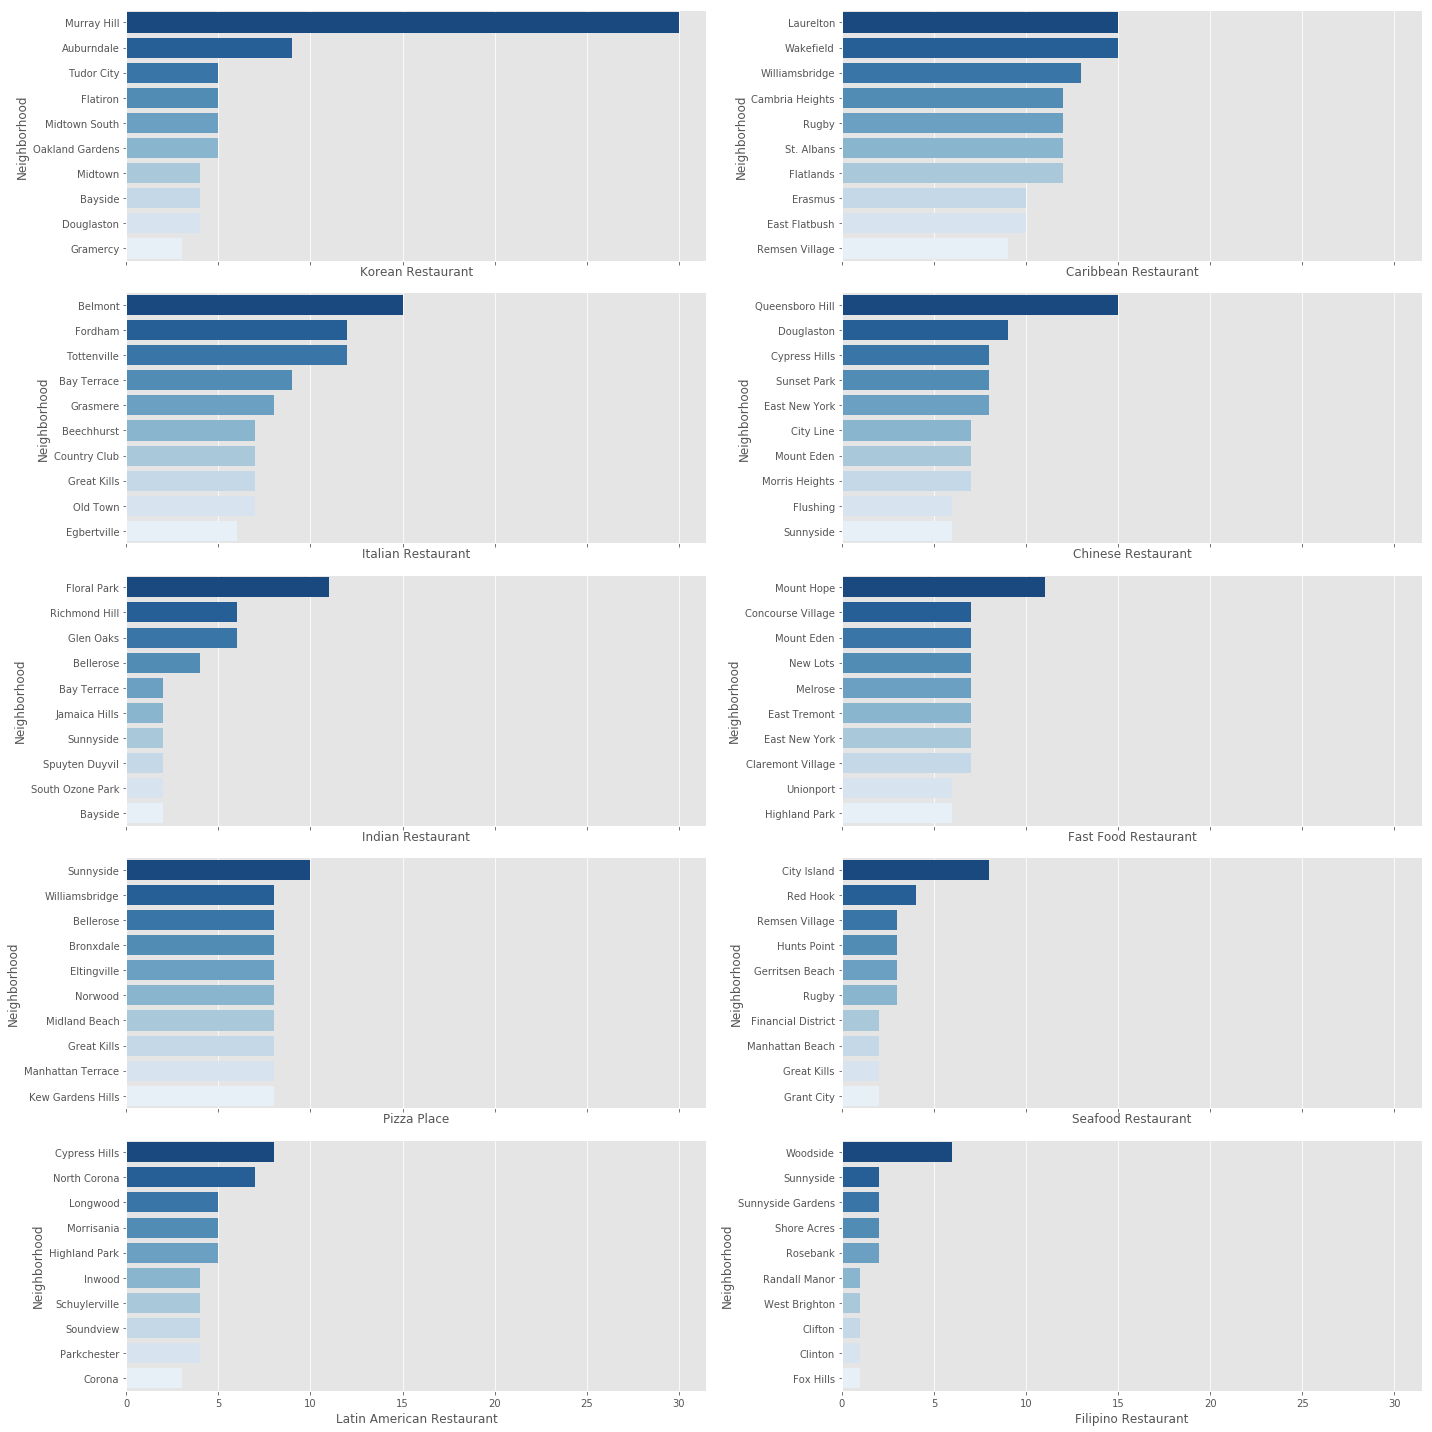

In [101]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes =plt.subplots(5, 2, figsize=(20,20), sharex=True)
axes = axes.flatten()

for ax, category in zip(axes, venue_top10_list):
    data = venue_counts[[category]].sort_values([category], ascending=False)[0:10]
    pal = sns.color_palette("Blues", len(data))
    sns.barplot(x=category, y=data.index, data=data, ax=ax, palette=np.array(pal[::-1]))

plt.tight_layout()
plt.show();

In [102]:

nyc_grouped = nyc_onehot.groupby('Neighborhood').mean().reset_index()
nyc_grouped.head()

,Neighborhood,Afghan Restaurant,African Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,Austrian Restaurant,BBQ Joint,Brazilian Restaurant,Burmese Restaurant,Burrito Place,Cajun / Creole Restaurant,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Chinese Restaurant,Chocolate Shop,Colombian Restaurant,Cuban Restaurant,Dim Sum Restaurant,Dosa Place,Dumpling Restaurant,Dutch Restaurant,Eastern European Restaurant,Egyptian Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,Food Service,French Restaurant,Fried Chicken Joint,German Restaurant,Greek Restaurant,Halal Restaurant,Hawaiian Restaurant,Himalayan Restaurant,Indian Chinese Restaurant,Indian Restaurant,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jewish Restaurant,Kebab Restaurant,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Lebanese Restaurant,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Modern Greek Restaurant,Moroccan Restaurant,New American Restaurant,Noodle House,North Indian Restaurant,Office,Paella Restaurant,Pakistani Restaurant,Persian Restaurant,Peruvian Restaurant,Pizza Place,Polish Restaurant,Portuguese Restaurant,Ramen Restaurant,Russian Restaurant,Salvadoran Restaurant,Seafood Restaurant,Shabu-Shabu Restaurant,Shanghai Restaurant,South American Restaurant,South Indian Restaurant,Southern / Soul Food Restaurant,Souvlaki Shop,Spanish Restaurant,Speakeasy,Sri Lankan Restaurant,Steakhouse,Sushi Restaurant,Szechuan Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Tex-Mex Restaurant,Thai Restaurant,Tibetan Restaurant,Tonkatsu Restaurant,Turkish Restaurant,Udon Restaurant,Ukrainian Restaurant,Varenyky restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant,Whisky Bar
0,Allerton,0.0,0.0,0.041667,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.125000,0.0,0.083333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.125000,0.0,0.0,0.0,0.125000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.166667,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.250000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.041667,0.0,0.041667,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Annadale,0.0,0.0,0.166667,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.055556,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.166667,0.0,0.055556,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.055556,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.333333,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.166667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Arden Heights,0.0,0.0,0.157895,0.0,0.0,0.000000,0.0,0.0,0.052632,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.105263,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.157895,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.105263,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.315789,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.105263,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Arlington,0.0,0.0,0.105263,0.0,0.0,0.052632,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.052632,0.0,0.052632,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.157895,0.0,0.0,0.0,0.052632,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.052632,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.105263,0.210526,0.052632,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.105263,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,

In [103]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [104]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

In [105]:
# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = nyc_grouped['Neighborhood']

In [106]:
for ind in np.arange(nyc_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(nyc_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Allerton,Pizza Place,Mexican Restaurant,Caribbean Restaurant,Fast Food Restaurant,Fried Chicken Joint
1,Annadale,Pizza Place,Sushi Restaurant,American Restaurant,Italian Restaurant,Japanese Restaurant
2,Arden Heights,Pizza Place,American Restaurant,Italian Restaurant,Sushi Restaurant,Mexican Restaurant
3,Arlington,Pizza Place,Fast Food Restaurant,American Restaurant,Peruvian Restaurant,Spanish Restaurant
4,Arrochar,Italian Restaurant,Pizza Place,Middle Eastern Restaurant,Chinese Restaurant,Latin American Restaurant


### Cluster Neighborhoods

Run k-means to count Neighborhoods for each cluster label for variable cluster size

In [107]:
nyc_grouped_clustering = nyc_grouped.drop('Neighborhood', 1)

In [108]:
sum_of_squared_distances = []
K = range(1,50)
for k in K:
    print(k, end=' ')
    kmeans = KMeans(n_clusters=k).fit(nyc_grouped_clustering)
    sum_of_squared_distances.append(kmeans.inertia_)

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 

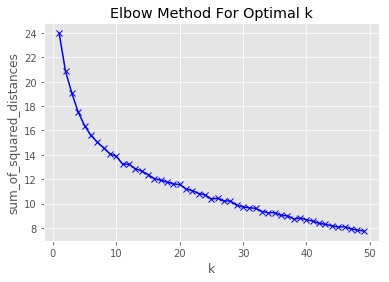

In [109]:
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('sum_of_squared_distances')
plt.title('Elbow Method For Optimal k');

In [110]:
# set number of clusters
kclusters = 8

# run k-means clustering
kmeans = KMeans(init="k-means++", n_clusters=kclusters, n_init=50).fit(nyc_grouped_clustering)

print(kmeans.labels_)

[0 1 1 0 2 7 4 2 5 7 5 4 2 0 5 7 1 4 2 7 2 1 2 7 4 4 1 5 1 5 0 4 1 0 1 5 3
 0 1 4 2 3 3 5 5 0 1 0 5 5 5 5 7 5 0 5 2 5 2 0 5 1 2 7 0 0 4 2 0 7 0 1 7 5
 5 5 4 3 0 7 0 5 4 3 3 1 4 2 4 4 1 1 3 7 4 4 0 5 3 4 7 2 5 5 5 2 4 1 5 7 4
 4 7 5 5 4 4 2 1 2 5 1 5 4 0 7 0 7 0 1 0 0 7 2 2 4 2 5 4 0 4 0 0 0 4 7 1 4
 0 3 4 2 6 5 7 5 7 5 0 5 4 2 4 1 2 5 7 4 0 4 1 0 1 1 5 5 1 4 4 5 7 4 0 4 7
 0 5 2 4 5 4 0 7 5 0 1 5 0 7 4 0 1 2 3 0 3 2 5 0 2 7 4 1 7 3 7 1 2 4 0 0 7
 7 5 4 4 5 4 3 7 2 4 4 4 3 4 7 7 2 3 1 1 3 1 4 7 7 2 7 5 7 0 1 3 3 5 7 4 3
 4 4 1 4 5 4 4 7 5 2 1 4 2 2 5 5 5 0 0 5 5 1 1 4 3 4 0 4 0 5 4 4 2 3 5 1 2
 3 0 3 1 4 4]


In [111]:
# add clustering labels
try:
    neighborhoods_venues_sorted.drop('Cluster Labels', axis=1)
except:
    neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

In [112]:
neighborhoods_venues_sorted.head(5)

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,0,Allerton,Pizza Place,Mexican Restaurant,Caribbean Restaurant,Fast Food Restaurant,Fried Chicken Joint
1,1,Annadale,Pizza Place,Sushi Restaurant,American Restaurant,Italian Restaurant,Japanese Restaurant
2,1,Arden Heights,Pizza Place,American Restaurant,Italian Restaurant,Sushi Restaurant,Mexican Restaurant
3,0,Arlington,Pizza Place,Fast Food Restaurant,American Restaurant,Peruvian Restaurant,Spanish Restaurant
4,2,Arrochar,Italian Restaurant,Pizza Place,Middle Eastern Restaurant,Chinese Restaurant,Latin American Restaurant


Finally, let's visualize the resulting clusters

In [113]:
nyc_merged = neighborhoods_venues_sorted.join(neighborhoods.set_index('Neighborhood'), on='Neighborhood')
nyc_merged.head()

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Borough,Latitude,Longitude
0,0,Allerton,Pizza Place,Mexican Restaurant,Caribbean Restaurant,Fast Food Restaurant,Fried Chicken Joint,Bronx,40.865788,-73.859319
1,1,Annadale,Pizza Place,Sushi Restaurant,American Restaurant,Italian Restaurant,Japanese Restaurant,Staten Island,40.538114,-74.178549
2,1,Arden Heights,Pizza Place,American Restaurant,Italian Restaurant,Sushi Restaurant,Mexican Restaurant,Staten Island,40.549286,-74.185887
3,0,Arlington,Pizza Place,Fast Food Restaurant,American Restaurant,Peruvian Restaurant,Spanish Restaurant,Staten Island,40.635325,-74.165104
4,2,Arrochar,Italian Restaurant,Pizza Place,Middle Eastern Restaurant,Chinese Restaurant,Latin American Restaurant,Staten Island,40.596313,-74.067124


In [114]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
colors_array = cm.rainbow(np.linspace(0, 1, kclusters))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(nyc_merged['Latitude'], nyc_merged['Longitude'], nyc_merged['Neighborhood'], nyc_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Clustering of Neighborhood

In [115]:

required_column_indices = [2,3,7]
required_column = [list(nyc_merged.columns.values)[i] for i in required_column_indices]
required_column_indices = [2,3,7]

Cluster 0

In [116]:
cluster_0 = nyc_merged.loc[nyc_merged['Cluster Labels'] == 0, nyc_merged.columns[1:12]]
cluster_0.head(5)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Borough,Latitude,Longitude
0,Allerton,Pizza Place,Mexican Restaurant,Caribbean Restaurant,Fast Food Restaurant,Fried Chicken Joint,Bronx,40.865788,-73.859319
3,Arlington,Pizza Place,Fast Food Restaurant,American Restaurant,Peruvian Restaurant,Spanish Restaurant,Staten Island,40.635325,-74.165104
13,Baychester,Pizza Place,Caribbean Restaurant,Fast Food Restaurant,Seafood Restaurant,Spanish Restaurant,Bronx,40.866858,-73.835798
30,Briarwood,Fast Food Restaurant,Pizza Place,Fried Chicken Joint,Caribbean Restaurant,South American Restaurant,Queens,40.710935,-73.811748
33,Broadway Junction,Fried Chicken Joint,Fast Food Restaurant,Mexican Restaurant,Pizza Place,Latin American Restaurant,Brooklyn,40.677861,-73.903317


In [117]:
for col in required_column:
    print(cluster_0[col].value_counts(ascending = False))
    print("---------------------------------------------")

Fast Food Restaurant               20
Pizza Place                        16
Fried Chicken Joint                 3
Latin American Restaurant           3
Caribbean Restaurant                2
Spanish Restaurant                  1
Southern / Soul Food Restaurant     1
Name: 1st Most Common Venue, dtype: int64
---------------------------------------------
Fast Food Restaurant         16
Pizza Place                  10
Caribbean Restaurant          8
Fried Chicken Joint           6
Latin American Restaurant     3
American Restaurant           1
Mexican Restaurant            1
Chinese Restaurant            1
Name: 2nd Most Common Venue, dtype: int64
---------------------------------------------
Bronx            18
Brooklyn         13
Queens            9
Manhattan         4
Staten Island     2
Name: Borough, dtype: int64
---------------------------------------------


Cluster 1

In [118]:
cluster_1 = nyc_merged.loc[nyc_merged['Cluster Labels'] == 1, nyc_merged.columns[1:12]]
cluster_1.head(5)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Borough,Latitude,Longitude
1,Annadale,Pizza Place,Sushi Restaurant,American Restaurant,Italian Restaurant,Japanese Restaurant,Staten Island,40.538114,-74.178549
2,Arden Heights,Pizza Place,American Restaurant,Italian Restaurant,Sushi Restaurant,Mexican Restaurant,Staten Island,40.549286,-74.185887
16,Bedford Park,Pizza Place,Chinese Restaurant,Fast Food Restaurant,Fried Chicken Joint,Southern / Soul Food Restaurant,Bronx,40.870185,-73.885512
21,Bellerose,Pizza Place,Indian Restaurant,Chinese Restaurant,Latin American Restaurant,Italian Restaurant,Queens,40.728573,-73.720128
26,Bloomfield,Pizza Place,Mexican Restaurant,Italian Restaurant,BBQ Joint,Whisky Bar,Staten Island,40.605779,-74.187256


In [119]:
for col in required_column:
    print(cluster_1[col].value_counts(ascending = False))
    print("---------------------------------------------")

Pizza Place    39
Name: 1st Most Common Venue, dtype: int64
---------------------------------------------
Chinese Restaurant           12
American Restaurant           5
Italian Restaurant            5
Sushi Restaurant              4
Fast Food Restaurant          2
Mexican Restaurant            2
Japanese Restaurant           2
Asian Restaurant              1
Russian Restaurant            1
Taco Place                    1
Indian Restaurant             1
Latin American Restaurant     1
Caribbean Restaurant          1
BBQ Joint                     1
Name: 2nd Most Common Venue, dtype: int64
---------------------------------------------
Staten Island    18
Queens           11
Brooklyn          6
Bronx             4
Name: Borough, dtype: int64
---------------------------------------------


Cluster 2

In [120]:
cluster_2 = nyc_merged.loc[nyc_merged['Cluster Labels'] == 2, nyc_merged.columns[1:12]]
cluster_2.head(5)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Borough,Latitude,Longitude
4,Arrochar,Italian Restaurant,Pizza Place,Middle Eastern Restaurant,Chinese Restaurant,Latin American Restaurant,Staten Island,40.596313,-74.067124
7,Astoria Heights,Greek Restaurant,Chinese Restaurant,Italian Restaurant,Pizza Place,Middle Eastern Restaurant,Queens,40.770317,-73.894680
12,Bay Terrace,Italian Restaurant,Pizza Place,Asian Restaurant,American Restaurant,Chinese Restaurant,Queens,40.782843,-73.776802
12,Bay Terrace,Italian Restaurant,Pizza Place,Asian Restaurant,American Restaurant,Chinese Restaurant,Staten Island,40.553988,-74.139166
18,Beechhurst,Italian Restaurant,Pizza Place,Sushi Restaurant,Japanese Restaurant,Chinese Restaurant,Queens,40.792781,-73.804365


In [121]:
for col in required_column:
    print(cluster_2[col].value_counts(ascending = False))
    print("---------------------------------------------")

Italian Restaurant     28
Pizza Place             4
Mexican Restaurant      2
American Restaurant     1
Greek Restaurant        1
Name: 1st Most Common Venue, dtype: int64
---------------------------------------------
Pizza Place             17
Italian Restaurant       7
Fast Food Restaurant     3
Mexican Restaurant       3
Asian Restaurant         2
Chinese Restaurant       2
American Restaurant      1
Thai Restaurant          1
Name: 2nd Most Common Venue, dtype: int64
---------------------------------------------
Staten Island    18
Queens            8
Bronx             5
Brooklyn          3
Manhattan         2
Name: Borough, dtype: int64
---------------------------------------------


Cluster 3

In [122]:
cluster_3 = nyc_merged.loc[nyc_merged['Cluster Labels'] == 3, nyc_merged.columns[1:12]]
cluster_3.head(5)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Borough,Latitude,Longitude
36,Brookville,Fried Chicken Joint,Caribbean Restaurant,Pizza Place,Chinese Restaurant,Fast Food Restaurant,Queens,40.660003,-73.751753
41,Cambria Heights,Caribbean Restaurant,Chinese Restaurant,Fast Food Restaurant,Fried Chicken Joint,Mexican Restaurant,Queens,40.692775,-73.735269
42,Canarsie,Caribbean Restaurant,Chinese Restaurant,Fast Food Restaurant,Pizza Place,Mexican Restaurant,Brooklyn,40.635564,-73.902093
77,East Flatbush,Caribbean Restaurant,Fried Chicken Joint,Fast Food Restaurant,Chinese Restaurant,Pizza Place,Brooklyn,40.641718,-73.936103
83,Eastchester,Caribbean Restaurant,Fast Food Restaurant,Pizza Place,Chinese Restaurant,Fried Chicken Joint,Bronx,40.887556,-73.827806


In [123]:
for col in required_column:
    print(cluster_3[col].value_counts(ascending = False))
    print("---------------------------------------------")

Caribbean Restaurant    21
American Restaurant      1
Fried Chicken Joint      1
Name: 1st Most Common Venue, dtype: int64
---------------------------------------------
Chinese Restaurant      7
Pizza Place             7
Fast Food Restaurant    6
Fried Chicken Joint     2
Caribbean Restaurant    1
Name: 2nd Most Common Venue, dtype: int64
---------------------------------------------
Brooklyn         8
Queens           8
Bronx            6
Staten Island    1
Name: Borough, dtype: int64
---------------------------------------------


Cluster 4

In [124]:
cluster_4 = nyc_merged.loc[nyc_merged['Cluster Labels'] == 4, nyc_merged.columns[1:12]]
cluster_4.head(5)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Borough,Latitude,Longitude
6,Astoria,Fast Food Restaurant,Ramen Restaurant,Pizza Place,Cajun / Creole Restaurant,Thai Restaurant,Queens,40.768509,-73.915654
11,Bay Ridge,Fast Food Restaurant,American Restaurant,Middle Eastern Restaurant,Italian Restaurant,Pizza Place,Brooklyn,40.625801,-74.030621
17,Bedford Stuyvesant,Pizza Place,Fast Food Restaurant,Mexican Restaurant,Fried Chicken Joint,French Restaurant,Brooklyn,40.687232,-73.941785
24,Bergen Beach,Pizza Place,Middle Eastern Restaurant,Sushi Restaurant,American Restaurant,Italian Restaurant,Brooklyn,40.615150,-73.898556
25,Blissville,Pizza Place,Italian Restaurant,Fast Food Restaurant,Mexican Restaurant,American Restaurant,Queens,40.737251,-73.932442


In [125]:
for col in required_column:
    print(cluster_4[col].value_counts(ascending = False))
    print("---------------------------------------------")

Pizza Place                    36
Fast Food Restaurant            5
Mexican Restaurant              4
Seafood Restaurant              3
Italian Restaurant              3
American Restaurant             2
Indian Restaurant               2
Thai Restaurant                 2
Asian Restaurant                1
Spanish Restaurant              1
Eastern European Restaurant     1
New American Restaurant         1
Turkish Restaurant              1
Filipino Restaurant             1
Japanese Restaurant             1
Name: 1st Most Common Venue, dtype: int64
---------------------------------------------
Fast Food Restaurant         11
Pizza Place                  10
American Restaurant           8
Italian Restaurant            8
Mexican Restaurant            6
Sushi Restaurant              3
Chinese Restaurant            3
Thai Restaurant               2
Asian Restaurant              2
Vietnamese Restaurant         2
Middle Eastern Restaurant     2
New American Restaurant       1
Latin American Res

Cluster 5 

In [126]:
cluster_5 = nyc_merged.loc[nyc_merged['Cluster Labels'] == 5, nyc_merged.columns[1:12]]
cluster_5.head(5)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Borough,Latitude,Longitude
8,Auburndale,Korean Restaurant,Greek Restaurant,Chinese Restaurant,American Restaurant,Italian Restaurant,Queens,40.761730,-73.791762
10,Battery Park City,Pizza Place,American Restaurant,Fast Food Restaurant,Italian Restaurant,French Restaurant,Manhattan,40.711932,-74.016869
14,Bayside,Korean Restaurant,American Restaurant,Greek Restaurant,Indian Restaurant,Fast Food Restaurant,Queens,40.766041,-73.774274
27,Boerum Hill,BBQ Joint,American Restaurant,Chinese Restaurant,Middle Eastern Restaurant,Korean Restaurant,Brooklyn,40.685683,-73.983748
29,Breezy Point,American Restaurant,Pizza Place,Whisky Bar,Greek Restaurant,English Restaurant,Queens,40.557401,-73.925512


In [127]:
for col in required_column:
    print(cluster_5[col].value_counts(ascending = False))
    print("---------------------------------------------")

American Restaurant        18
Italian Restaurant          8
Korean Restaurant           8
Pizza Place                 6
Mexican Restaurant          4
Japanese Restaurant         3
Seafood Restaurant          2
French Restaurant           2
Ramen Restaurant            2
New American Restaurant     2
Dim Sum Restaurant          1
BBQ Joint                   1
Thai Restaurant             1
Name: 1st Most Common Venue, dtype: int64
---------------------------------------------
American Restaurant          19
Italian Restaurant           10
Pizza Place                   8
French Restaurant             5
New American Restaurant       2
Middle Eastern Restaurant     2
Japanese Restaurant           2
Korean Restaurant             2
Ramen Restaurant              2
Greek Restaurant              2
Dim Sum Restaurant            1
Mexican Restaurant            1
Chinese Restaurant            1
South American Restaurant     1
Name: 2nd Most Common Venue, dtype: int64
--------------------------------

Cluster 6 

In [128]:
cluster_6 = nyc_merged.loc[nyc_merged['Cluster Labels'] == 6, nyc_merged.columns[1:12]]
cluster_6.head(5)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Borough,Latitude,Longitude
152,Lighthouse Hill,Italian Restaurant,Whisky Bar,Greek Restaurant,Empanada Restaurant,English Restaurant,Staten Island,40.576506,-74.137927


In [129]:
for col in required_column:
    print(cluster_6[col].value_counts(ascending = False))
    print("---------------------------------------------")

Italian Restaurant    1
Name: 1st Most Common Venue, dtype: int64
---------------------------------------------
Whisky Bar    1
Name: 2nd Most Common Venue, dtype: int64
---------------------------------------------
Staten Island    1
Name: Borough, dtype: int64
---------------------------------------------


Cluster 7

In [130]:
cluster_7 = nyc_merged.loc[nyc_merged['Cluster Labels'] == 7, nyc_merged.columns[1:12]]
cluster_7.head(5)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Borough,Latitude,Longitude
5,Arverne,Chinese Restaurant,Taco Place,Caribbean Restaurant,American Restaurant,Pizza Place,Queens,40.589144,-73.791992
9,Bath Beach,Japanese Restaurant,Fast Food Restaurant,Chinese Restaurant,Vietnamese Restaurant,Sushi Restaurant,Brooklyn,40.599519,-73.998752
15,Bayswater,Chinese Restaurant,Pizza Place,Fried Chicken Joint,Caribbean Restaurant,American Restaurant,Queens,40.611322,-73.765968
19,Bellaire,Chinese Restaurant,Pizza Place,Fast Food Restaurant,Italian Restaurant,Spanish Restaurant,Queens,40.733014,-73.738892
23,Bensonhurst,Chinese Restaurant,Sushi Restaurant,Pizza Place,Fast Food Restaurant,Japanese Restaurant,Brooklyn,40.611009,-73.995180


In [131]:
for col in required_column:
    print(cluster_7[col].value_counts(ascending = False))
    print("---------------------------------------------")

Chinese Restaurant           25
Pizza Place                   7
Fast Food Restaurant          2
Sushi Restaurant              1
Indian Restaurant             1
Mexican Restaurant            1
Japanese Restaurant           1
Latin American Restaurant     1
Name: 1st Most Common Venue, dtype: int64
---------------------------------------------
Chinese Restaurant      9
Fast Food Restaurant    8
Pizza Place             5
Caribbean Restaurant    3
Italian Restaurant      3
Taco Place              2
Cantonese Restaurant    2
Spanish Restaurant      1
Mexican Restaurant      1
Fried Chicken Joint     1
Sushi Restaurant        1
Korean Restaurant       1
Turkish Restaurant      1
American Restaurant     1
Name: 2nd Most Common Venue, dtype: int64
---------------------------------------------
Queens           19
Brooklyn         10
Bronx             6
Staten Island     3
Manhattan         1
Name: Borough, dtype: int64
---------------------------------------------
